<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: Data Scientist в Segmento Екатерина Демидова

# <center>Домашнее задание 2. <br> Визуальный анализ данных о публикациях на Хабрахабре</center>

In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## Загрузка и знакомство с данными

Для работы вам понадобятся данные из нашего учебного конкурса на kaggle [«Прогноз популярности статьи на Хабре»](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). Файл **`howpop_train.csv`** уже лежит в нашем репозитории в каталоге **`data`**, но его можно скачать и с Kaggle.

In [2]:
df = pd.read_csv('data/howpop_train.csv')

In [3]:
df.shape

(134137, 17)

In [4]:
df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


Избавимся сразу от переменных, названия которых заканчиваются на `_lognorm` (нужны для соревнования на Kaggle). Выберем их с помощью `filter()` и удалим `drop`-ом:

In [5]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: столбцы 
        inplace = True) # избавляет от необходимости сохранять датасет

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137,181307,81766.4,18284,115565,182666,257401,314088
polling,134137,0.0352252,0.184349,False,0,0,0,True
content_len,134137,7516.93,8724.77,1,2179,4949,9858,352471
comments,134137,39.626,62.399,0,7,19,48,2266
favs,134137,71.9999,145.854,0,8,27,78,8718
views,134137,16631,31479.8,3,2100,7600,18700,1.73e+06
votes_plus,133566,35.5369,42.4611,0,11,22,45,1466
votes_minus,133566,8.05004,11.3983,0,2,5,10,445


In [7]:
df.describe(include = ['object', 'bool'] # бинарные и категориальные переменные
           ).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
url,134137,134137,https://habrahabr.ru/company/webnames/blog/121...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
domain,134137,2,habrahabr.ru,97048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
published,134137,130291,2011-06-14 15:52:00,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,97657,22077,@alizar,5292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flow,97048,6,develop,53318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
polling,134137,NaN,NaN,NaN,0.0352252,0.184349,False,0,0,0,True
title,134137,133628,"Интересные события, произошедшие в выходные",56,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Столбец **`published`** (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу `datetime`:

In [9]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst = True)
print(df.published.dtype)

object
datetime64[ns]


Создадим несколько столбцов на основе данных о времени публикации:

In [10]:
df['year'] = [d.year for d in df.published]
df['month'] = [d.month for d in df.published]
df['day'] = [d.day for d in df.published]
df['dayofweek'] = [d.isoweekday() for d in df.published]
df['hour'] = [d.hour for d in df.published]

-----
Теперь Ваша очередь. В каждом пункте предлагается построить картинку и с ее помощью ответить на вопрос в [форме](https://docs.google.com/forms/d/e/1FAIpQLSf3b5OG8zX_nLQBQ-t20c6M5Auz-VUL-yxj8Fm9_o_XWDBTrg/viewform?c=0&w=1). Конечно, можно попытаться ответить на все вопросы только с Pandas, без картинок, но мы советуем Вам потренироваться строить (красивые) визуализации.   

## 1\. В каком месяце (и какого года) было больше всего публикаций?

* март 2016,
* март 2015,
* апрель 2015,
* апрель 2016.

In [34]:
df.domain.unique()

array(['habrahabr.ru', 'geektimes.ru'], dtype=object)

In [21]:
df.columns

Index(['url', 'domain', 'post_id', 'published', 'author', 'flow', 'polling',
       'content_len', 'title', 'comments', 'favs', 'views', 'votes_plus',
       'votes_minus', 'views_lognorm', 'favs_lognorm', 'comments_lognorm',
       'year', 'month', 'dayofweek', 'hour'],
      dtype='object')

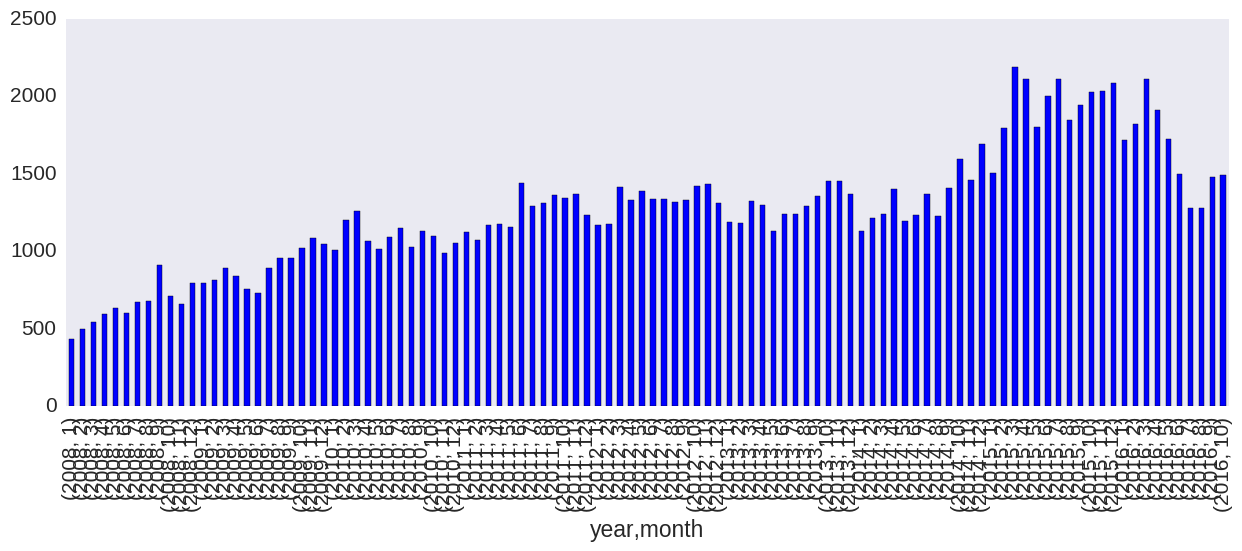

In [17]:
df.groupby(['year','month'])['post_id'].count().plot(kind = 'bar')

## 2\. Проанализируйте публикации в этом месяце

Выберите один или несколько вариантов:

* На графике не заметны какие-либо выбросы или аномалии,
* Один или несколько дней сильно выделяются из общей картины,
* На хабре _всегда_ больше статей, чем на гиктаймсе,
* По субботам на гиктаймс и на хабрахабр публикуют примерно одинаковое число статей.

Подсказки: постройте график зависимости числа публикаций от дня; используйте параметр `hue`; не заморачивайтесь сильно с ответами и не ищите скрытого смысла :)

In [31]:
d = df[(df['year']==2015)&(df['month']==3)]

In [58]:
d['counts'] = d.groupby(['day'])['post_id'].transform('count')

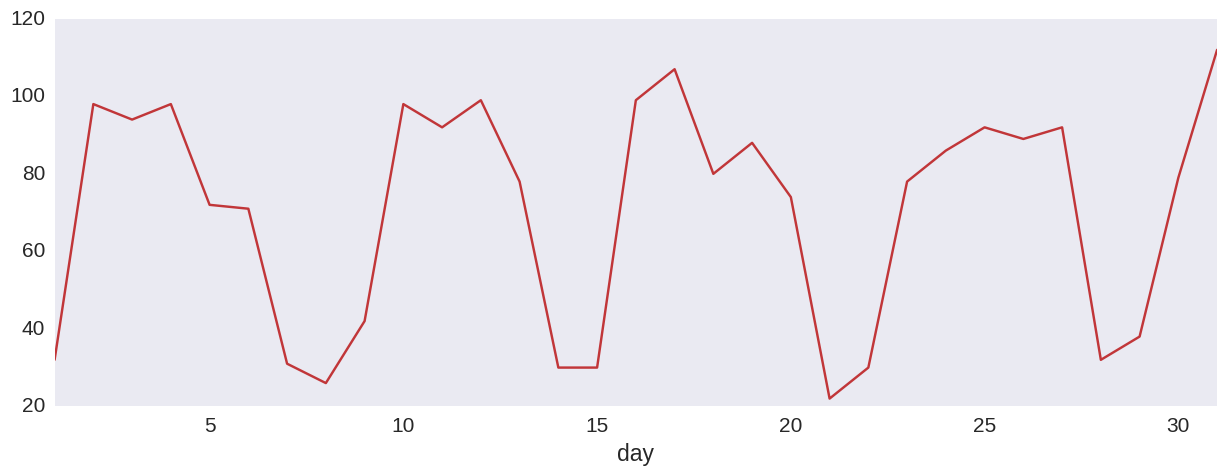

In [32]:
d.groupby(['day'])['post_id'].count().plot()

In [35]:
df.domain.unique()

array(['habrahabr.ru', 'geektimes.ru'], dtype=object)

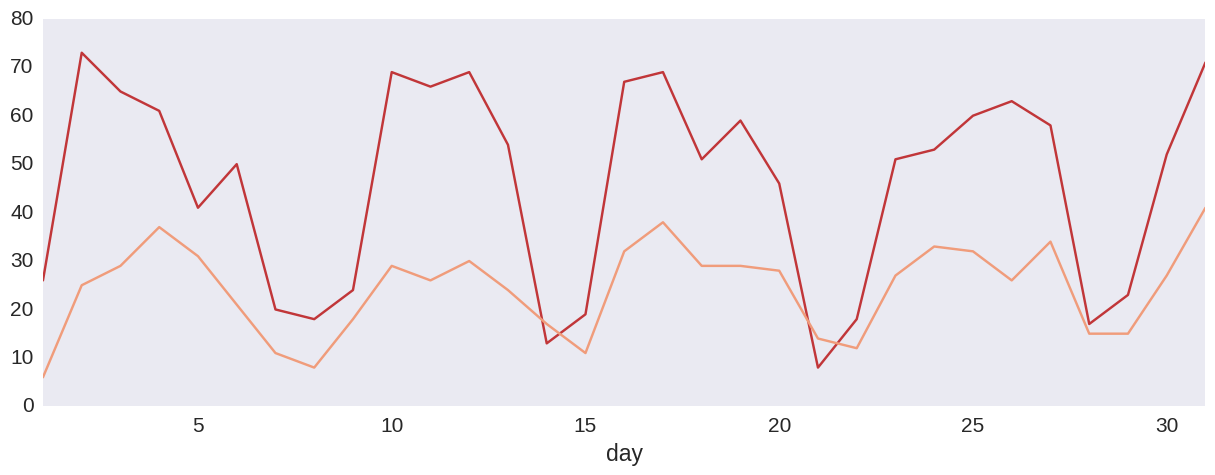

In [41]:
d[d['domain'] == 'habrahabr.ru'].groupby(['day'])['post_id'].count().plot()
d[d['domain'] == 'geektimes.ru'].groupby(['day'])['post_id'].count().plot()

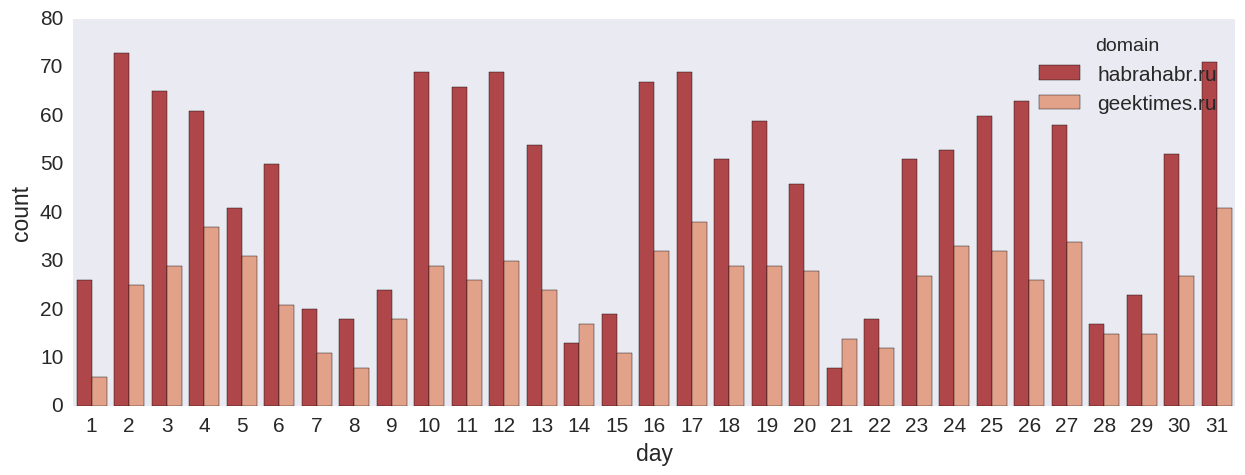

In [57]:

sns.countplot(x='day', hue='domain', data=d)

In [44]:
d['dayofweek'].unique()

array([7, 1, 2, 3, 4, 5, 6])

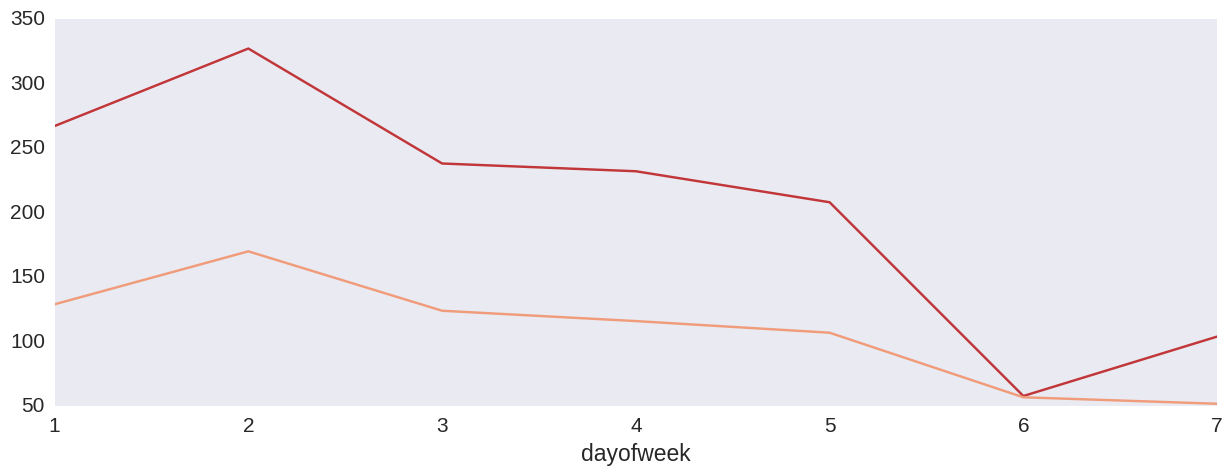

In [45]:
d[d['domain'] == 'habrahabr.ru'].groupby(['dayofweek'])['post_id'].count().plot()
d[d['domain'] == 'geektimes.ru'].groupby(['dayofweek'])['post_id'].count().plot()

In [68]:
df.columns

Index(['url', 'domain', 'post_id', 'published', 'author', 'flow', 'polling',
       'content_len', 'title', 'comments', 'favs', 'views', 'votes_plus',
       'votes_minus', 'views_lognorm', 'favs_lognorm', 'comments_lognorm',
       'year', 'month', 'dayofweek', 'hour', 'day'],
      dtype='object')

## 3\. Когда лучше всего публиковать статью?

* Больше всего просмотров набирают статьи, опубликованные в 12 часов дня;
* У опубликованных в 10 утра постов больше всего комментариев;
* Больше всего просмотров набирают статьи, опубликованные в 6 часов утра;
* Максимальное число комментариев на гиктаймсе набрала статья, опубликованная в 9 часов вечера;
* На хабре дневные статьи комментируют чаще, чем вечерние.

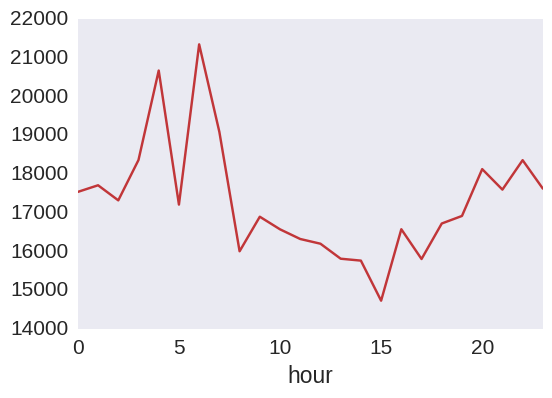

In [71]:
df.groupby(['hour'])['views'].mean().plot()

In [73]:
df['domain'].unique()

array(['habrahabr.ru', 'geektimes.ru'], dtype=object)

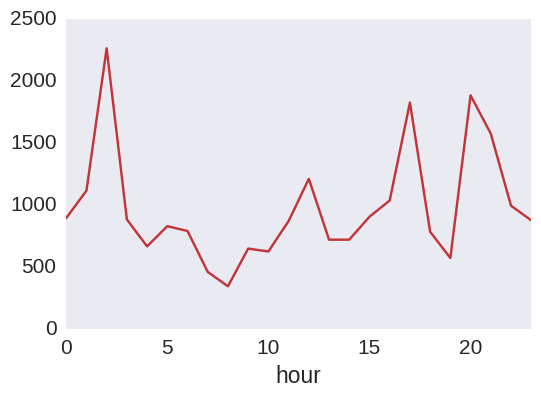

In [75]:
df[df['domain']=='geektimes.ru'].groupby(['hour'])['comments'].max().plot()

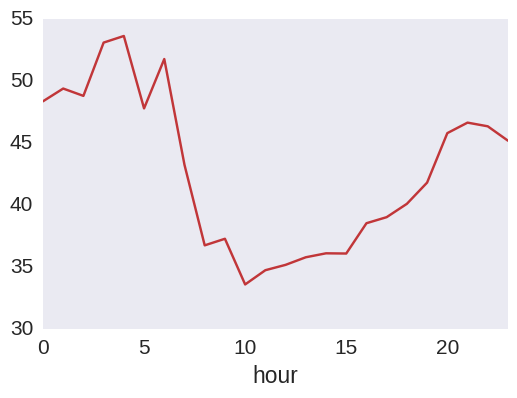

In [72]:
df.groupby(['hour'])['comments'].mean().plot()

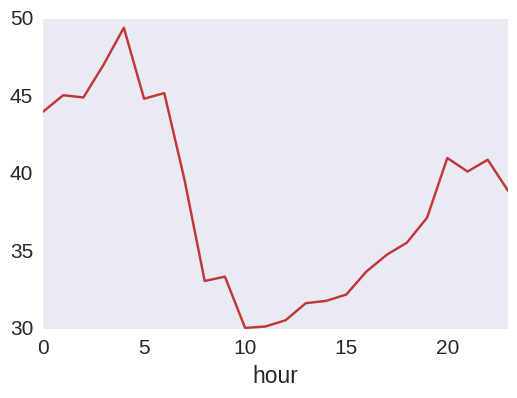

In [74]:
df[df['domain']=='habrahabr.ru'].groupby(['hour'])['comments'].mean().plot()

## 4\. Кого из топ-20 авторов чаще всего минусуют?

* @Mordatyj
* @Mithgol
* @alizar
* @ilya42

In [87]:
df.columns

Index(['url', 'domain', 'post_id', 'published', 'author', 'flow', 'polling',
       'content_len', 'title', 'comments', 'favs', 'views', 'votes_plus',
       'votes_minus', 'views_lognorm', 'favs_lognorm', 'comments_lognorm',
       'year', 'month', 'dayofweek', 'hour', 'day'],
      dtype='object')

In [ ]:
df.groupby(['autor'])['votes_minus'].mean()

In [95]:
data = []
l = list(df['author'].value_counts()[:20].index)
for s in l:
    data.append(df[df['author'] == s].votes_minus.mean())


In [96]:
data

[7.928191489361702,
 3.834996814610321,
 4.276946879834966,
 2.4985185185185186,
 1.1673783091374894,
 4.831916902738432,
 9.974643423137877,
 15.286912751677852,
 20.481081081081083,
 7.471454880294659,
 5.196998123827392,
 6.216796875,
 4.407982261640798,
 4.018018018018018,
 5.518518518518518,
 13.654676258992806,
 1.516431924882629,
 2.42,
 9.350785340314136,
 16.49171270718232]

In [97]:
# создаем линию для числа вышедших игр 
trace1 = go.Scatter(
    x=l,
    y=data,
    name='Number of games released'
)

# определяем массив данных и задаем title графика в layout
dat = [trace1]
layout = {'title': 'Statistics of video games'}

# cоздаем объект Figure и визуализируем его
fig = go.Figure(data=dat, layout=layout)
iplot(fig, show_link=False)

## 5\. Сравните субботы и понедельники

Правда ли, что по субботам авторы пишут в основном днём, а по понедельникам — в основном вечером?

In [12]:
df.columns

Index(['url', 'domain', 'post_id', 'published', 'author', 'flow', 'polling',
       'content_len', 'title', 'comments', 'favs', 'views', 'votes_plus',
       'votes_minus', 'year', 'month', 'day', 'dayofweek', 'hour'],
      dtype='object')

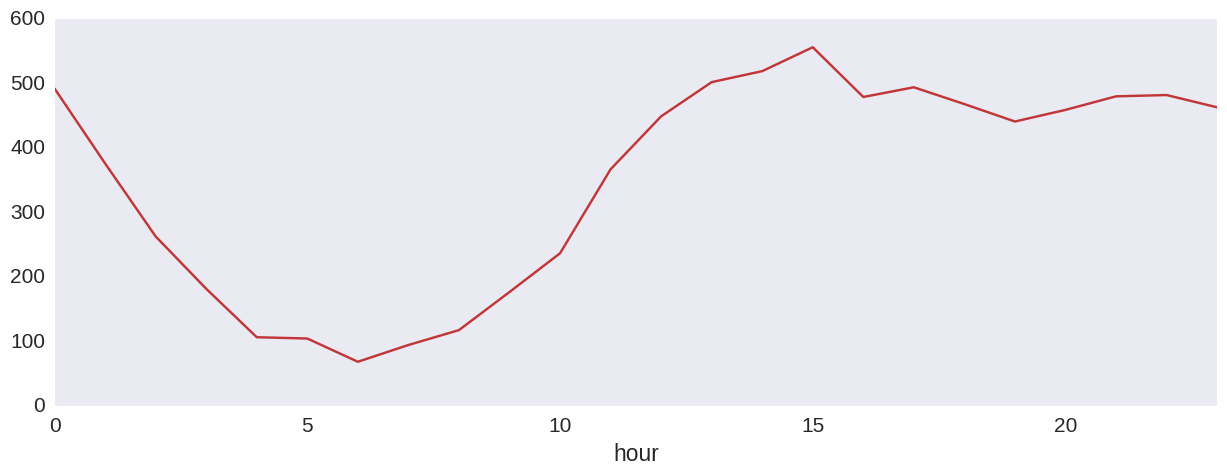

In [13]:
df[df['dayofweek'] ==6].groupby(['hour'])['post_id'].count().plot()

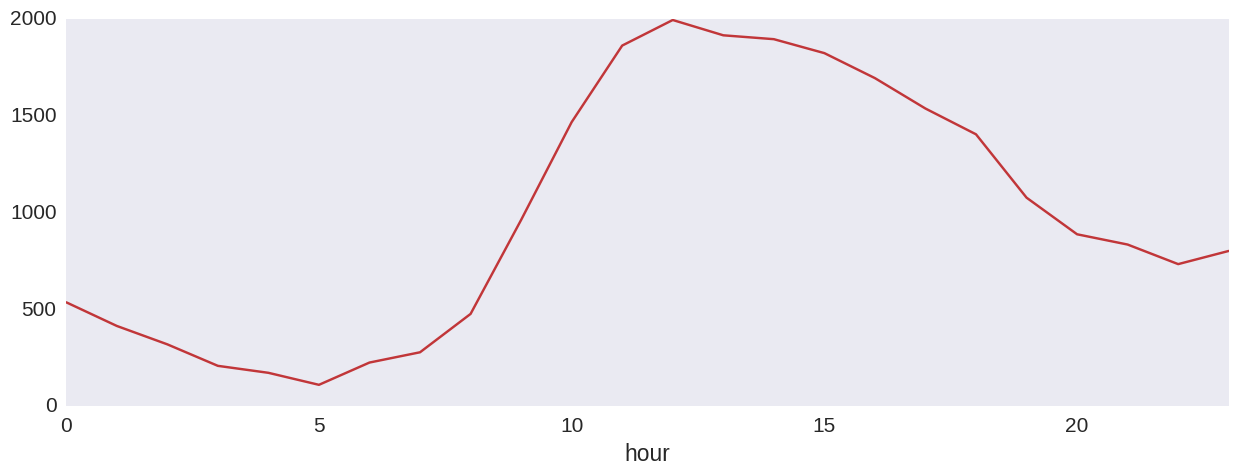

In [14]:
df[df['dayofweek'] ==1].groupby(['hour'])['post_id'].count().plot()

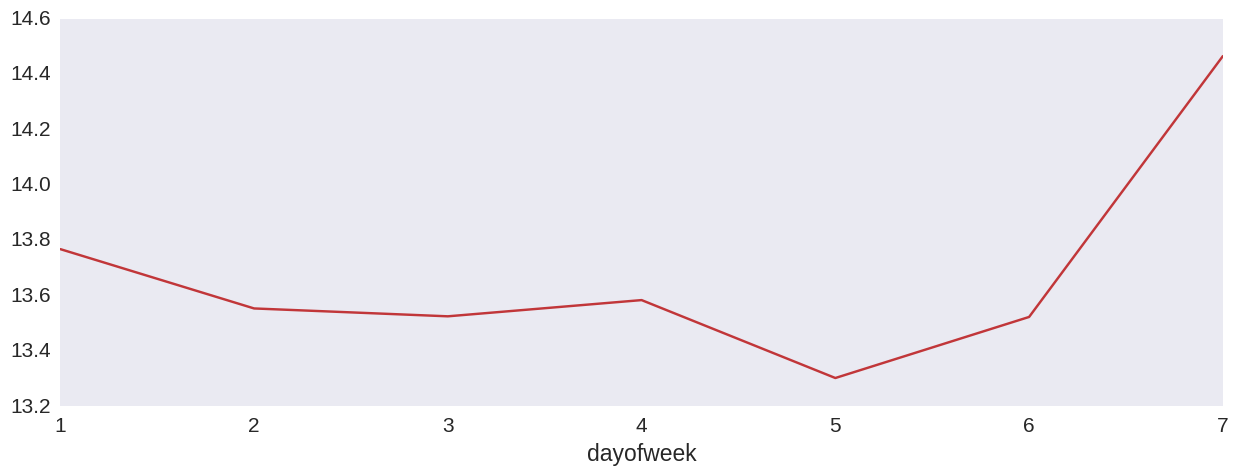

In [15]:
df.groupby(['dayofweek'])['hour'].mean().plot()